In [1]:
import pandas as pd 
import numpy as np 
from textblob import TextBlob
import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


import json, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import ToktokTokenizer


from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import gensim

from sentiment_analysis_spanish import sentiment_analysis
import nltk
import pyLDAvis.gensim_models

import random
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
#df = pd.read_excel('Resultados Touchpoint APP Personas del 1abr al 24 May.xlsx')
df = pd.read_excel('Touchpoint APP Personas 1 May al 8 Ago Prepago.xlsx')
df.head(2)

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Q15 - Topic Sentiment Label,Q15 - Topic Sentiment Score,Q15 - Topics,Q20 - Parent Topics,Q20 - Sentiment Polarity,Q20 - Sentiment Score,Q20 - Sentiment,Q20 - Topic Sentiment Label,Q20 - Topic Sentiment Score,Q20 - Topics
0,Fecha de inicio,Fecha de finalización,Tipo de respuesta,Dirección IP,Progreso,Duración (en segundos),Finalizado,Fecha registrada,ID de respuesta,Apellido del destinatario,...,Q15 - Topic Sentiment Label,Q15 - Topic Sentiment Score,Q15 - Topics,Q20 - Parent Topics,Q20 - Sentiment Polarity,Q20 - Sentiment Score,Q20 - Sentiment,Q20 - Topic Sentiment Label,Q20 - Topic Sentiment Score,Q20 - Topics
1,2021-05-01 00:01:09,2021-05-01 00:02:59,IP Address,181.78.16.235,100,110,True,2021-05-01 00:02:59.714000,R_3ISGyOV01BzngPO,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df = df.drop([0], axis=0)
df.head(2)

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Q15 - Topic Sentiment Label,Q15 - Topic Sentiment Score,Q15 - Topics,Q20 - Parent Topics,Q20 - Sentiment Polarity,Q20 - Sentiment Score,Q20 - Sentiment,Q20 - Topic Sentiment Label,Q20 - Topic Sentiment Score,Q20 - Topics
1,2021-05-01 00:01:09,2021-05-01 00:02:59,IP Address,181.78.16.235,100,110,True,2021-05-01 00:02:59.714000,R_3ISGyOV01BzngPO,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-04-30 00:08:19,2021-04-30 00:10:59,IP Address,191.156.153.227,38,160,False,2021-05-01 00:11:00.156000,R_22t2EpjmNZEoqFT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.Q2_NPS_GROUP.value_counts()

Promotor     25789
Detractor     9377
Pasivo        8274
Name: Q2_NPS_GROUP, dtype: int64

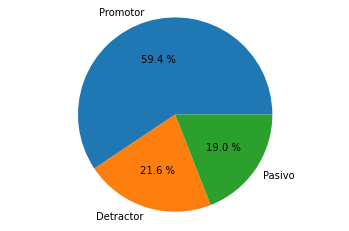

In [5]:
A = df.Q2_NPS_GROUP.value_counts()
indices = A.index
plt.pie(A, labels=indices, autopct="%0.1f %%")
plt.axis("equal")
plt.show()

####  Funciones para Limpieza de texto

In [6]:
def limpiar_texto(texto):
    """
    Función para realizar la limpieza de un texto dado.
    """
    # Eliminamos los caracteres especiales
    texto = re.sub(r'\W', ' ', str(texto))
    # Eliminamos comas y /
    texto = re.sub(r',', ' ', str(texto))
    texto = re.sub(r'/', ' ', str(texto))
    # Eliminado las palabras que tengo un solo caracter
    texto = re.sub(r'\s+[a-zA-Z]\s+', ' ', texto)
    # Sustituir los espacios en blanco en uno solo
    texto = re.sub(r'\s+', ' ', texto, flags=re.I)
    # Convertimos textos a minusculas
    texto = texto.lower()
    return texto

In [7]:
nltk.download('stopwords')
STOPWORDS = set(stopwords.words("spanish"))
def filtrar_stopword_digitos(tokens):
    """
    Filtra stopwords y digitos de una lista de tokens.
    """
    return [token for token in tokens if token not in STOPWORDS 
            and not token.isdigit()]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CristhianJohnatanIzq\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
stemmer = SnowballStemmer("spanish")
def stem_palabras(tokens):
    """
    Reduce cada palabra de una lista dada a su raíz.
    """
    return [stemmer.stem(token) for token in tokens]

In [9]:
def Limpiar_Caracter(texto):
    if len(texto) == 1 or texto == ',':
        texto = ''
    else:
        texto = texto
    return texto

###  Seleccion de Preguntas

In [10]:
Qs=['Q4','Q10','Q12','Q15','Q18','Q20']

###  Analisis de sentimientos

In [11]:
sentiment = sentiment_analysis.SentimentAnalysisSpanish()

In [12]:
dfSent=df.fillna('')

In [86]:
tokenizer = ToktokTokenizer() 
Lista_general=[]
for column in Qs:
    dfSent["Tokens_"+column]=dfSent[column].apply(limpiar_texto)
    dfSent["Sent_"+column] =  np.where(dfSent["Tokens_"+column]!='', dfSent[column].apply(sentiment.sentiment)*2-1,'')
    
dfSent.head(2)

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Tokens_Q10,Sent_Q10,Tokens_Q12,Sent_Q12,Tokens_Q15,Sent_Q15,Tokens_Q18,Sent_Q18,Tokens_Q20,Sent_Q20
1,2021-05-01 00:01:09,2021-05-01 00:02:59,IP Address,181.78.16.235,100,110,True,2021-05-01 00:02:59.714,R_3ISGyOV01BzngPO,,...,,,,,,,,,,
2,2021-04-30 00:08:19,2021-04-30 00:10:59,IP Address,191.156.153.227,38,160,False,2021-05-01 00:11:00.156,R_22t2EpjmNZEoqFT,,...,,,,,,,,,,


##### Fin Analisis de Sentimiento

####  Preprocesamiento

In [87]:
tokenizer = ToktokTokenizer() 
Lista_general=[]
dfc = dfSent[dfSent['Q2_NPS_GROUP']!='Promotor']
for column in Qs:    
    dfc["Tokens_"+column] = dfc["Tokens_"+column].apply(tokenizer.tokenize)
    dfc["Tokens_"+column] = dfc["Tokens_"+column].apply(filtrar_stopword_digitos)
    dfc["Tokens_"+column] = dfc["Tokens_"+column].apply(stem_palabras)
    #solo ciertas Qs son agregadas
    if column in ('Q4','Q10','Q12','Q15','Q18','Q20') :
        listAux = dfc["Tokens_"+column].tolist()
        listAux = [x for x in listAux if x!= []]
        #print("Qs")
        print(column, len(listAux))
        Lista_general = Lista_general+listAux

Q4 3345
Q10 853
Q12 2251
Q15 5928
Q18 4924
Q20 1366


###  Modelo de Tópicos

In [122]:
### Funciones para modelo de tópicos
def make_bigrams(texts,bigram_mod):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts,bigram_mod,trigram_mod):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def impresionTopicos(mod,nPalabras,nTopicos):
    topicos = mod.print_topics(num_words=nPalabras, num_topics=nTopicos)
    for topico in topicos:
        print(topico)    
        
def impresionTopicosLimp(mod,nPalabras,nTopicos):
    #Impresion limpia de Tópicos
    topicos = mod.print_topics(num_words=nPalabras, num_topics=nTopicos)
    i=0
    for topico in topicos:
        i=i+1
        textoAux = re.sub(r'\W', ' ', str(topico))
        textoAux = re.sub(r'\s+[a-zA-Z]\s+', ' ', textoAux)
        textoAux = re.sub(r'[0-9]', ' ', textoAux)
        textoAux = re.sub(r'\s+', ' ', textoAux, flags=re.I)
        print(str(i),textoAux)

In [91]:
bigram = gensim.models.Phrases(Lista_general, min_count=5, threshold=10) 
trigram = gensim.models.Phrases(bigram[Lista_general], threshold=10)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

data_words_bigrams = make_bigrams(Lista_general,bigram_mod)

diccionario = Dictionary(data_words_bigrams)
print(f'Número de tokens: {len(diccionario)}')

diccionario.filter_extremes(no_below=2, no_above = 0.9)
print(f'Número de tokens: {len(diccionario)}')

corpus = [diccionario.doc2bow(noticia) for noticia in data_words_bigrams]

Número de tokens: 5019
Número de tokens: 2372


In [92]:
numeroTopicos=5

In [93]:
lda = LdaModel(corpus=corpus, id2word=diccionario, 
               num_topics=numeroTopicos, random_state=35, 
               chunksize=1000, iterations=200, passes=40, alpha='auto')

In [121]:
impresionTopicos(lda,5,20)

(0, '0.085*"servici" + 0.044*"buen" + 0.043*"internet" + 0.038*"mal" + 0.036*"señal"')
(1, '0.095*"pag" + 0.070*"factur" + 0.052*"plan" + 0.036*"consult" + 0.031*"cuent"')
(2, '0.059*"dat" + 0.048*"recarg" + 0.032*"si" + 0.032*"inform" + 0.029*"graci"')
(3, '0.075*"app" + 0.064*"pued" + 0.060*"dej" + 0.047*"clar" + 0.045*"ver"')
(4, '0.067*"pud" + 0.063*"registr" + 0.050*"equip" + 0.048*"funcion" + 0.044*"numer"')


In [123]:
impresionTopicosLimp(lda,15,20)

1  servici buen internet mal señal mejor llam sirv nunc solucion pesim asesor client wifi moment 
2  pag factur plan consult cuent pod clar_hog necesit opcion aparec hog line realiz cambi quier 
3  dat recarg si inform graci sald activ consum paquet deb compr_paquet sab cobr benefici pas 
4  app pued dej clar ver hac ingres aplic lent dic permit actualiz sol eleg entrar 
5  pud registr equip funcion numer celul bien compr telefon famili_amig demor gust nuev excelent equip_financi 


In [96]:
lda_display = pyLDAvis.gensim_models.prepare(lda, corpus, diccionario, sort_topics=False)
pyLDAvis.display(lda_display)

In [97]:
pyLDAvis.save_html(lda_display, 'lda_General_4_V3.html')

####  fin simplificación

###  Clasificación de los textos en tópicos

In [98]:
dfc2 = dfc.fillna('')

In [99]:
for column in Qs:    
    dfc2["Tokens_"+column+"_T"] = dfc2["Tokens_"+column]
    dfc2["Tokens_"+column] =  dfc2[column].apply(limpiar_texto)
    dfc2["Tokens_"+column] =  dfc2[column].apply(Limpiar_Caracter)

In [100]:
columnasDefTopico=['Q12','Q15','Q18']
dfc2['Opinion'] = ''
for i in dfc2.index:
    for column in columnasDefTopico: 
        dfc2.loc[i,'Opinion']=dfc2.loc[i,'Opinion']+str(dfc2.loc[i,"Tokens_"+column])+" "
dfc2.head(2)

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Sent_Q18,Tokens_Q20,Sent_Q20,Tokens_Q4_T,Tokens_Q10_T,Tokens_Q12_T,Tokens_Q15_T,Tokens_Q18_T,Tokens_Q20_T,Opinion
4,2021-05-01 00:14:21,2021-05-01 00:15:37,IP Address,181.53.12.201,100,76,True,2021-05-01 00:15:38.223,R_udHanua3i8beZtT,,...,,,,[ningun],[],[],[],[],[],
9,2021-05-01 00:56:56,2021-05-01 00:58:36,IP Address,191.156.52.30,100,100,True,2021-05-01 00:58:37.141,R_XjMcEuP3zshnpF7,,...,,Me parece bien,-0.8938357315867129,"[qued, sald, carg, app, pod, recarg, vez]",[],[],[],[],"[parec, bien]",


In [101]:
dfc2['Opinion'] = dfc2['Opinion'].apply(tokenizer.tokenize)
dfc2['Opinion'] = dfc2['Opinion'].apply(filtrar_stopword_digitos)
dfc2['Opinion'] = dfc2['Opinion'].apply(stem_palabras)
dfc2['Opinion'] 

4                                                       []
9                                                       []
10                                            [mal, señal]
11       [me, cambi, x, mes, oper, regres, nuev, sub, m...
13       [se, demor, carg, despues, dic, sient, trabaj,...
                               ...                        
48043    [antes, mas, facil, encontr, hac, cos, ya, pue...
48048                                                   []
48049                                                   []
48050                     [bn, no, entend, bien, graci, 😊]
48052            [es, lent, app, se, demor, entrar, aplic]
Name: Opinion, Length: 22263, dtype: object

In [102]:
for i in dfc2.index:    
    if dfc2.loc[i,'Opinion']==[]:
        dfc2.drop([i], inplace=True)
dfc2.head(2)

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Sent_Q18,Tokens_Q20,Sent_Q20,Tokens_Q4_T,Tokens_Q10_T,Tokens_Q12_T,Tokens_Q15_T,Tokens_Q18_T,Tokens_Q20_T,Opinion
10,2021-05-01 01:11:12,2021-05-01 01:13:28,IP Address,190.26.155.7,100,136,True,2021-05-01 01:13:29.173,R_x5YL4kva6EbeuWJ,,...,,,,[],[],[],"[mal, señal]",[],[],"[mal, señal]"
11,2021-05-01 01:15:49,2021-05-01 01:21:26,IP Address,186.29.191.43,100,336,True,2021-05-01 01:21:26.392,R_3ltBuR7i97QbFAM,,...,,,,"[bastant, tiemp, usted, sub, plan, line]",[],[],"[cambi, mes, oper, regres, nuev, sub, mil, pes...",[],[],"[me, cambi, x, mes, oper, regres, nuev, sub, m..."


In [103]:
dfc2['Tópico'] = ""
sumaTopicos = [0]*(numeroTopicos+1)
for i in dfc2.index:
    bow_comentario = diccionario.doc2bow(dfc2.loc[i,'Opinion'])
    distribucion_noticia = lda[bow_comentario]
    dist_contrib = [topico[1] for topico in lda[bow_comentario]]
    dfc2.loc[i,'Tópico']=dist_contrib.index(max(dist_contrib))+1
    
    # sumar pertenencias a los tópicos
    for idx, val in enumerate(dist_contrib):
        sumaTopicos[idx+1]=sumaTopicos[idx+1]+dist_contrib[idx]    

In [104]:
dfc2.Tópico.value_counts()

4    2887
2    1719
1    1229
3     752
5     544
Name: Tópico, dtype: int64

#####  Validación asignación de Tópicos

In [30]:
for index,score in sorted(lda[diccionario.doc2bow(dfc2.loc[10,'Opinion'])], key=lambda tup: -1*tup[1]):
    print("Score:{}\t Topic:{}".format(score,lda.print_topic(index,5)))

Score:0.34969139099121094	 Topic:0.085*"servici" + 0.044*"buen" + 0.043*"internet" + 0.038*"mal" + 0.036*"señal"
Score:0.20666146278381348	 Topic:0.075*"app" + 0.064*"pued" + 0.060*"dej" + 0.047*"clar" + 0.045*"ver"
Score:0.1831425577402115	 Topic:0.095*"pag" + 0.070*"factur" + 0.052*"plan" + 0.036*"consult" + 0.031*"cuent"
Score:0.14199717342853546	 Topic:0.059*"dat" + 0.048*"recarg" + 0.032*"si" + 0.032*"inform" + 0.029*"graci"
Score:0.11850738525390625	 Topic:0.067*"pud" + 0.063*"registr" + 0.050*"equip" + 0.048*"funcion" + 0.044*"numer"


In [31]:
bow_comentario = diccionario.doc2bow(dfc2.loc[10,'Opinion'])
distribucion_noticia = lda[bow_comentario]
dist_contrib = [topico[1] for topico in lda[bow_comentario]]
dist_contrib

[0.3496914, 0.18314257, 0.14199719, 0.20666148, 0.1185074]

####  fin validacion

###  zoom al topico_4  número 3

In [126]:
numeroTopicos=4
topicoZoom=4

In [127]:
## Quitar pag pactur
dfc2Zoom=dfc2.copy()
dfc2Zoom['contienePagFact']=dfc2Zoom['Opinion'].apply(lambda x: 1 if 'pag' in x else 0)
dfc2Zoom=dfc2Zoom[dfc2Zoom['contienePagFact']==0]
dfc2Zoom=dfc2Zoom[dfc2Zoom['Tópico']==topicoZoom]

In [128]:
# Repite el proceso de topicos

In [129]:
Lista_generalZoom=[]
for column in Qs:   
    if column in ('Q4','Q10','Q12','Q15','Q18','Q20') :
        listAux = dfc2Zoom["Tokens_"+column+"_T"].tolist()
        listAux = [x for x in listAux if x!= []]
        Lista_generalZoom = Lista_generalZoom+listAux

In [130]:
bigramZoom = gensim.models.Phrases(Lista_generalZoom, min_count=5, threshold=10) 
trigramZoom = gensim.models.Phrases(bigramZoom[Lista_generalZoom], threshold=10)
bigram_modZoom = gensim.models.phrases.Phraser(bigramZoom)
trigram_modZoom = gensim.models.phrases.Phraser(trigramZoom)
data_words_bigramsZoom = make_bigrams(Lista_generalZoom,bigram_modZoom)
diccionarioZoom = Dictionary(data_words_bigramsZoom)
diccionarioZoom.filter_extremes(no_below=2, no_above = 0.9)
corpusZoom = [diccionarioZoom.doc2bow(noticia) for noticia in data_words_bigramsZoom]

In [131]:
ldaZoom = LdaModel(corpus=corpusZoom, id2word=diccionarioZoom, 
               num_topics=numeroTopicos, random_state=35, 
               chunksize=1000, iterations=200, passes=40, alpha='auto')

In [132]:
lda_display = pyLDAvis.gensim_models.prepare(ldaZoom, corpusZoom, diccionarioZoom, sort_topics=False)
pyLDAvis.display(lda_display)

In [133]:
dfc2Zoom['TópicoZoom'] = ""
sumaTopicos = [0]*(numeroTopicos+1)
for i in dfc2Zoom.index:
    bow_comentario = diccionarioZoom.doc2bow(dfc2Zoom.loc[i,'Opinion'])
    distribucion_noticia = ldaZoom[bow_comentario]
    dist_contrib = [topico[1] for topico in ldaZoom[bow_comentario]]
    dfc2Zoom.loc[i,'TópicoZoom']=dist_contrib.index(max(dist_contrib))+1
    
    # sumar pertenencias a los tópicos
    for idx, val in enumerate(dist_contrib):
        sumaTopicos[idx+1]=sumaTopicos[idx+1]+dist_contrib[idx] 

In [134]:
dfc2Zoom.TópicoZoom.value_counts()

4    1585
3     758
2     233
1      62
Name: TópicoZoom, dtype: int64

In [135]:
impresionTopicosLimp(ldaZoom,15,20)

1  recarg sald llam necesit facil deb compr_paquet busc muestr se pas encuentr tiemp encontr ver_consum 
2  ver clar servici factur plan sal clar_hog mal si inform equip abrir clar_vide hog acced 
3  app lent aplic dat funcion pud carg actualiz internet sirv vec compr demor intent pagin 
4  dej ingres pued hac eleg numer dic entrar registr permit famili_amig cuent consult cambi pod 


######  fin Zoom

####  Construcción Tabla Final 

In [136]:
TablaFinal=df.copy()
for column in Qs:    
    TablaFinal["Sent_"+column]=dfSent["Sent_"+column] 
TablaFinal['Opinion']=dfc2['Opinion']
TablaFinal['Topico']=dfc2['Tópico']
TablaFinal['TópicoZoom']=dfc2Zoom['TópicoZoom']

In [137]:
TablaFinal.to_csv('TablaFinalV2.csv', index=False, sep=';')